In [1]:
! pip install import-ipynb

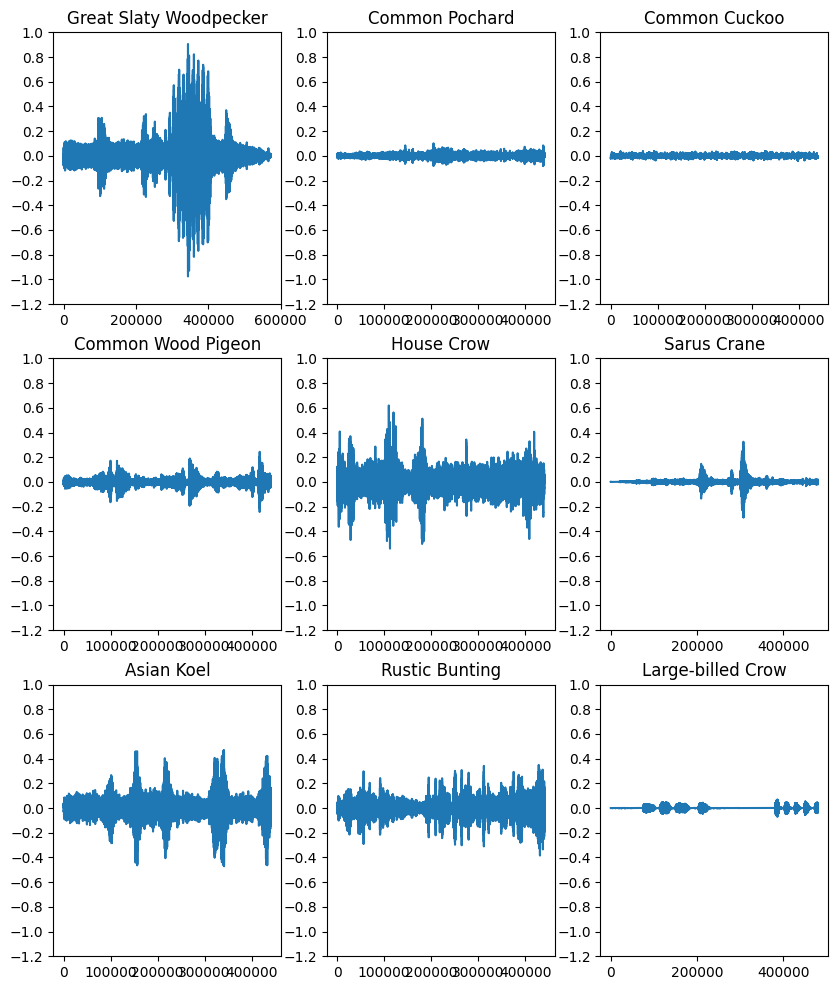

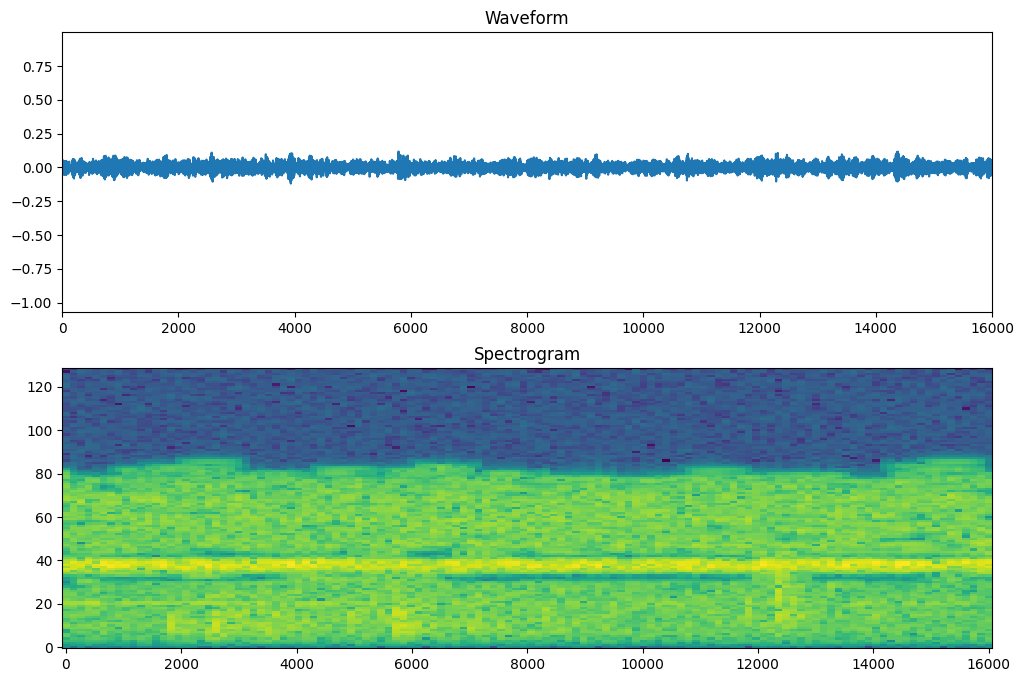

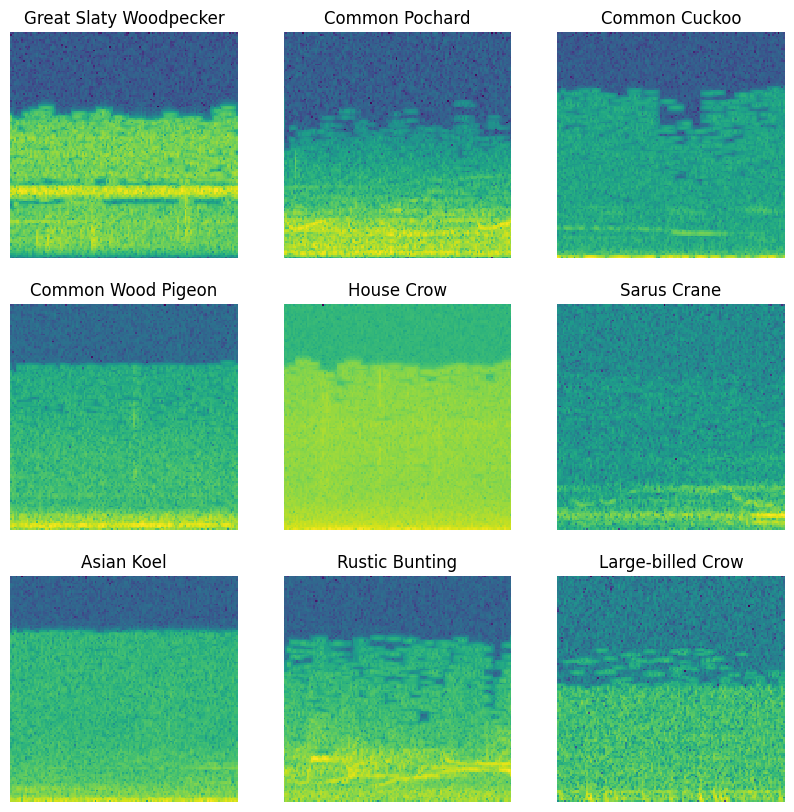

In [2]:
%run extractAudio.ipynb

In [3]:
RESIZING = 64 # 32 standard 

In [4]:
from tensorflow import keras
from keras import layers
from keras import models

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),

        # Downsample the input.
        layers.Resizing(RESIZING, RESIZING),

        # Convolutional layer 1
        layers.Conv2D(RESIZING, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Normalize.
        norm_layer,
        
        # Convolutional layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional layer 3
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),



        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        # Use softmax activation for multi-class classification
        layers.Dense(num_labels, activation='softmax')
    ]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 normalization (Normalizati  (None, 31, 31, 64)        3         
 on)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)       

In [5]:
model.compile(
    optimizer           = tf.keras.optimizers.Adam(),
    loss                = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics             = ["accuracy"],
)

In [6]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data     = val_ds,
    epochs              = EPOCHS,
    callbacks           = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




82/82 [==============================] - 45s 503ms/step - loss: 3.3785 - accuracy: 0.0819 - val_loss: 3.1423 - val_accuracy: 0.1299
Epoch 2/10
82/82 [==============================] - 13s 157ms/step - loss: 3.0782 - accuracy: 0.1290 - val_loss: 2.8628 - val_accuracy: 0.2019
Epoch 3/10
82/82 [==============================] - 13s 154ms/step - loss: 2.9220 - accuracy: 0.1718 - val_loss: 2.8042 - val_accuracy: 0.2269
Epoch 4/10
82/82 [==============================] - 12s 151ms/step - loss: 2.7635 - accuracy: 0.2224 - val_loss: 2.7139 - val_accuracy: 0.2504
Epoch 5/10
82/82 [==============================] - 13s 153ms/step - loss: 2.6741 - accuracy: 0.2465 - val_loss: 2.6394 - val_accuracy: 0.2723
Epoch 6/10
82/82 [==============================] - 14s 175ms/step - loss: 2.5054 - accuracy: 0.3029 - val_loss: 2.5978 - val_accuracy: 0.2879
Epoch 7/10
82/82 [==============================] - 14s 176ms/step - loss: 2.4306 - accuracy: 0.3161 - val_loss: 2.5034 - val_accuracy: 0.3036
Epoch 8/

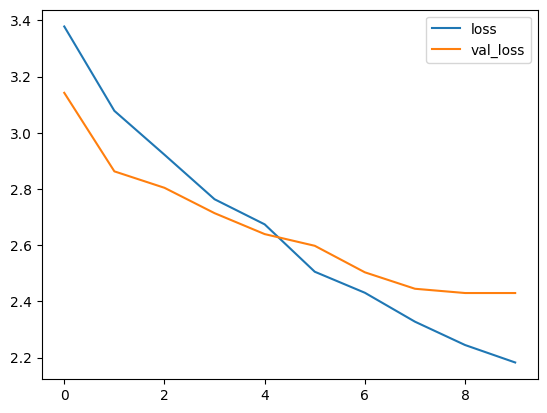

In [7]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

In [8]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [9]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

22/22 [==============================] - 1s 29ms/step
Test set accuracy: 36%


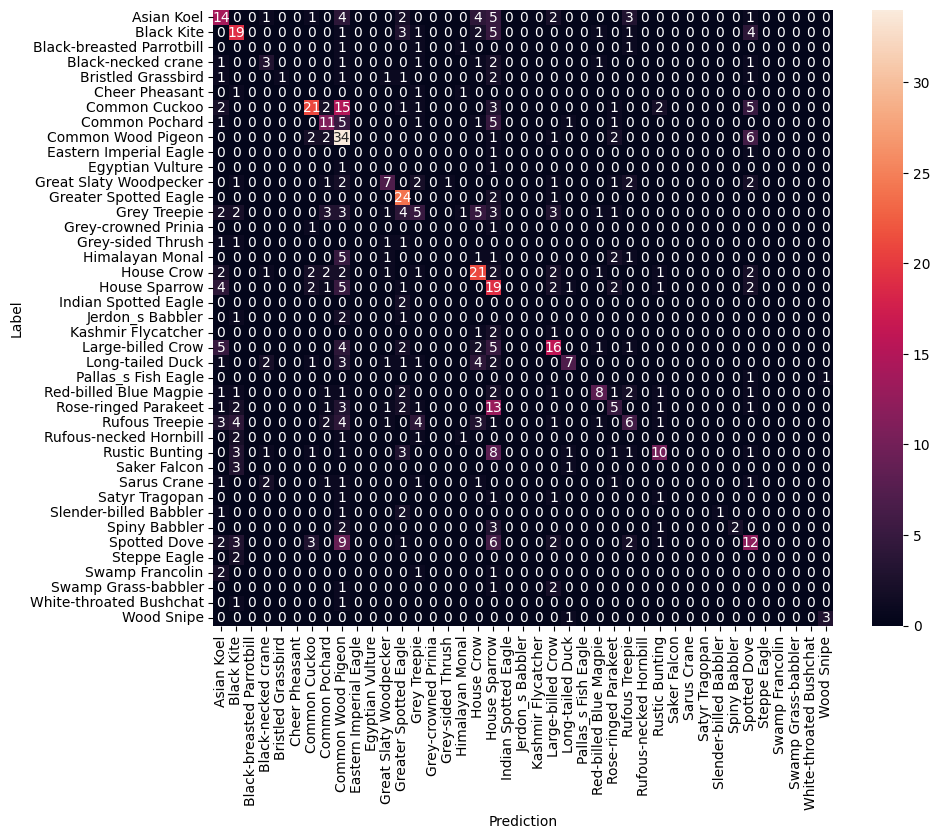

In [10]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=birds, yticklabels=birds, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()